# Aproksimacija funkcije $f(x,y) = \sin \left( \sqrt{x^2 + y^2}\right), x, y \in [-6, 6]$ pomoću neuronske mreže

Authori: Marko Hajba, Gita Pejović, Marijana Špoljarić

Ustanova: Veleučilište u Virovitici / Virovitica University of Applied Sciences

Cilj skripte je demonstrirati proces učenja funkcije $f(x,y) = \sin \left( \sqrt{x^2 + y^2}\right), x, y \in [-6, 6]$ pomoću guste neuronske mreže.

Neuronske mreže su univerzalni aproksimatori i poznato je da mogu proizvoljno točno aproksimirati neprekidnu funkciju na nekom intervalu. Prilikom treniranja neuronske mreže crtat ćemo trenutno rješenje kako bi vizualno uočili kako neuronska mreža uči danu funkciju.

## Za početak učitavamo potrebne pakete:

In [74]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
print(tf.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
import math
import scipy
import dolfin

%load_ext tensorboard

2.3.1
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# FEniCS

Definiramo *mesh*, prostor funkcija i zadajemo funkciju.

FEniCS će nam omogućiti lakšu analizu točnosti rješenja tijekom i nakon treniranja neuronske mreže

In [75]:
a = -6
b = 6
nx = 100
ny = 100

Plotting a RectangleMesh
(90601,)


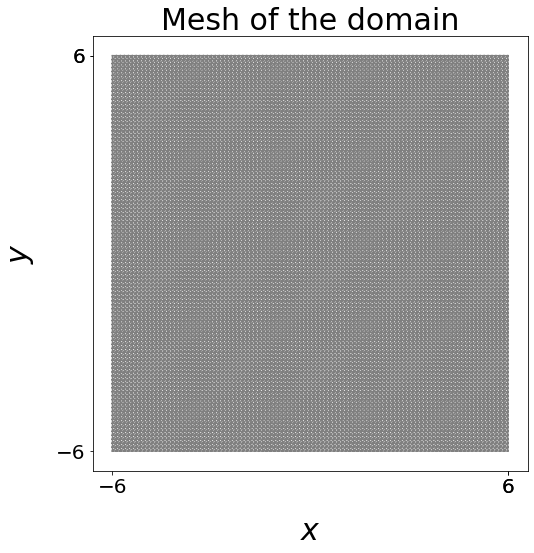

In [76]:
#####  FEniCS  #############

## Mesh
from dolfin import *

mesh = RectangleMesh(Point(a, a), Point(b, b), nx, ny ) #, "right/left")
print("Plotting a RectangleMesh")
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plot(mesh)
plt.title("Mesh of the domain", fontsize = 30)
plt.xticks([a, (b-a)/2, b], fontsize = 20)
plt.yticks([a, (b-a)/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)

## build essential boundary conditions
def u0_boundary(x, on_boundary):
    return on_boundary

V = FunctionSpace(mesh, 'Lagrange', 3)

func = Function(V)
print(func.vector()[:].shape)

In [77]:
funcF = Function(V)
f1 = Expression("sin(sqrt(pow(x[0], 2) + pow(x[1], 2)))",  degree = 3)
funcF.vector()[:] = funcF.vector()[:] + ( interpolate(f1, V) ).vector()


/usr/lib/petsc/lib/python3/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


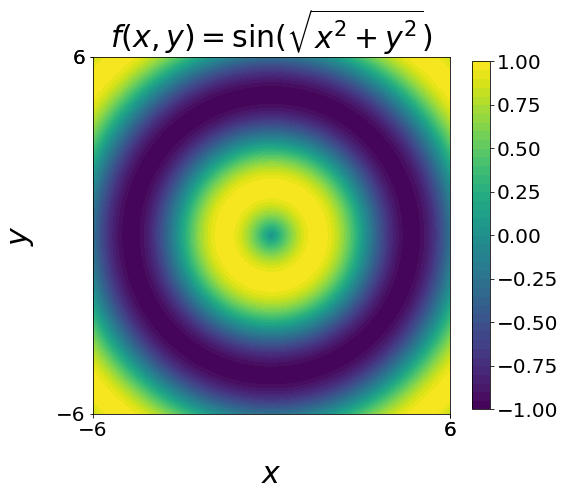

In [78]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cb = plot(funcF, interactive=True)
plt.title('$f(x, y)=\sin (\sqrt{x^2 + y^2})$', fontsize = 30)
plt.xticks([a, (b-a)/2, b], fontsize = 20)
plt.yticks([a, (b-a)/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20,  pad=0.05)  # orientation="horizontal",
cbar.ax.tick_params(labelsize=20) 

## Arhitektura i važni hiperparametri neuronske mreže

Izgrađujemo arhitekturu neuronske mreže, koja osim ulaznog i izlaznog sloja sadrži i dva skrivena sloja. Svaki skriveni sloj sadrži 30 neurona. Za optimizacijsku metoda koristimo Adam sa stopom učenja $ \alpha = 0.0005$. Koristit ćemo MSE funkciju gubitka. Koristeći definiranu arhitekturu, funkciju gubitka i optimizacijsku metodu, kompajliramo model.

In [79]:
# Arhitektura neuronske mreže
inputs = layers.Input(shape = (2, ))
h1 = layers.Dense(30, activation=tf.nn.tanh)(inputs)
h2 = layers.Dense(30, activation=tf.nn.tanh)(h1)
h3 = layers.Dense(30, activation=tf.nn.tanh)(h2)
out = layers.Dense(1)(h3)

## definiramo model
model = tf.keras.Model(inputs, out)

# definiramo optimizer i njegove parametre te kompajliramo model:
optim = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MSE, optimizer=optim)

# arhitektura neuronske mreze i broj parametara:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                90        
_________________________________________________________________
dense_17 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_18 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 31        
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________


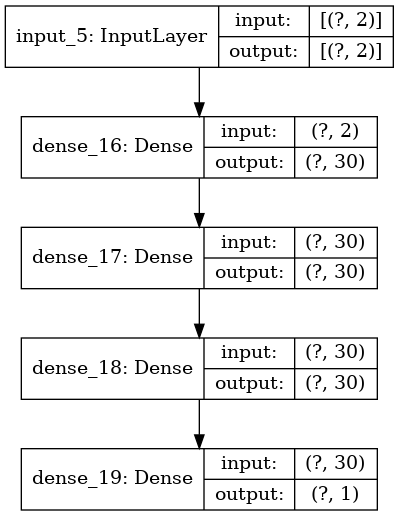

In [80]:
## Prikaz grafa neuronske mreže
graph = tf.keras.utils.plot_model(model, show_shapes=True) 
graph

## Ulazni i izlazni podaci
Definiramo ulazne i izlazne podatke, domena ulaznih podataka $x$ i $y$ je segment $[-6, 6]$ , a izlazni podaci $z = f(x, y)=2\sin \left(\sqrt{x^2+y^2}\right)$.

Za crtanje grafa koristimo metodu tricontourf() iz paketa matplotlib

Broj tocaka za treniranje neuronske mreže:  58081


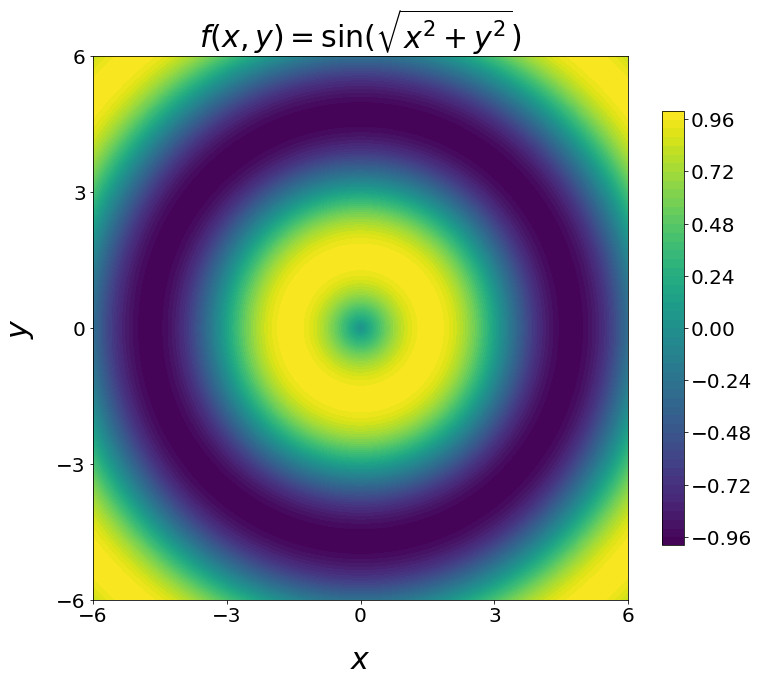

In [81]:
## podaci za treniranje
h = 0.05
xy = np.mgrid[a:b+h:h, a:b+h:h].reshape(2,-1).T
z = np.sin(np.sqrt(xy[:, 0] ** 2 + xy[:, 1] ** 2))

## grafički prikaz:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
cb = ax.tricontourf(xy[:, 0], xy[:, 1], z, levels=50, cmap = 'viridis')
plt.title('$f(x, y)=\sin ( \sqrt {x^2+y^2} ) $', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 

print('Broj tocaka za treniranje neuronske mreže: ', len(xy))

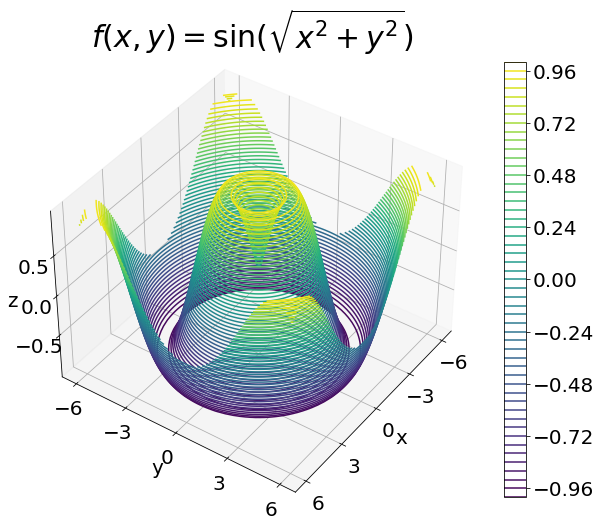

In [82]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))
    
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 2, 2)
ax = plt.axes(projection='3d')
cb = ax.contour3D(X, Y, Z, 50, cmap='viridis')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('z', fontsize = 20)
ax.zaxis.set_tick_params(labelsize=20)
ax.view_init(40, 35)
plt.title('$f(x, y)=\sin ( \sqrt {x^2+y^2} ) $', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 

## Callback metoda za stopu učenja:

- definiramo funkciju za vrijednosti stope učenja, ovisno o epohi
- kreiramo objekt koji implementira funkciju za promjenu stope učenja pomoću definirane funkcije

In [83]:
## Learning rate callback

def scheduler(epoch):
    if epoch < 5000:
        return 0.005
#    elif epoch < 20000:
#       return 0.001
    else:
        return 0.0005

def scheduler2(epoch):
    if epoch < 5000:
        return 0.00005
    else:
        return 0.00005


LRcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
LRcallback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)

## Treniranje neuronske mreže
Treniramo neuronsku mrežu koristeći ulazne podatke, veličinu grupe postavljamo na vrijednost broja ulaznih podataka i broj prolaza kroz podatke, a ukupni broj epoha je 200000. Crtat ćemo za epohe 1, 10, 1000, 5000, 10000 i 200000 funkciju i aproksimaciju $NM(x)$ kako bismo pratili napredak neuronske mreže. Izračunat ćemo i funkciju gubitka u tim epohama.

In [84]:
# Prije početka treniranja (epoha 0):
y_epoch0 = model(xy) ## prije početka treniranja
weights0 = model.get_weights()

In [85]:
## treniranje neuronske mreže
################ epoch 1: ###################
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "./logs", write_images=True, write_grads=True, histogram_freq = 10)

start = time.time()
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 1, callbacks = [LRcallback, tensorboard_callback] )
y_epoch1 = model(xy)
loss = []
loss.append(history.history['loss'])
loss_epoch1 = []
loss_epoch1 = history.history['loss'][len(loss_epoch1)-1]
print('Funkcija gubitka nakon 1 epohe:', loss_epoch1)

################ epoch 10: ###################
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 9, callbacks = [LRcallback] )
y_epoch10 = model(xy)
loss.append(history.history['loss'])
loss_epoch10 = []
loss_epoch10 = history.history['loss'][len(loss_epoch10)-1]
print('Funkcija gubitka nakon 10 epoha:', loss_epoch10)

################ epoch 1000: ###################
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 990, callbacks = [LRcallback] )
y_epoch1000 = model(xy)
loss.append(history.history['loss'])
loss_epoch1000 = []
loss_epoch1000 = history.history['loss'][len(loss_epoch1000)-1]
print('Funkcija gubitka nakon 1000 epoha:', loss_epoch1000)

################ epoch 5000: ###################
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 4000, callbacks = [LRcallback] )
y_epoch5000 = model(xy)
loss.append(history.history['loss'])
loss_epoch5000 = []
loss_epoch5000 = history.history['loss'][len(loss_epoch5000)-1]
print('Funkcija gubitka nakon 5000 epoha:', loss_epoch5000)

################ epoch 10000: ###################
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 5000, callbacks = [LRcallback] )
y_epoch10000 = model(xy)
loss.append(history.history['loss'])
loss_epoch10000 = []
loss_epoch10000 = history.history['loss'][len(loss_epoch10000)-1]
print('Funkcija gubitka nakon 10000 epoha:', loss_epoch10000)

################ epoch 20000: ###################
history = model.fit(xy, z, ## ulazni podaci, izlazni podaci
            batch_size = len(xy), verbose=0, epochs = 190000, callbacks = [LRcallback2, tensorboard_callback]  )
y_epoch20000 = model(xy)
loss.append(history.history['loss'])
loss_epoch20000 = []
loss_epoch20000 = history.history['loss'][len(loss_epoch20000)-1]
print('Funkcija gubitka nakon 200000 epoha:', loss_epoch20000)

####################################################
print('Vrijeme treniranja: ', np.round(time.time() - start, 2), ' s')

Funkcija gubitka nakon 1 epohe: 0.5125173926353455
Funkcija gubitka nakon 10 epoha: 0.4874003529548645
Funkcija gubitka nakon 1000 epoha: 0.0014842445962131023
Funkcija gubitka nakon 5000 epoha: 0.0009637628099881113
Funkcija gubitka nakon 10000 epoha: 5.152110679773614e-05
Funkcija gubitka nakon 200000 epoha: 2.233897021142184e-06
Vrijeme treniranja:  461.43  s


## Crtamo graf funkcije gubitka

- plavo - sve epohe
- crveno - odabrane epohe

dict_keys(['loss', 'lr'])


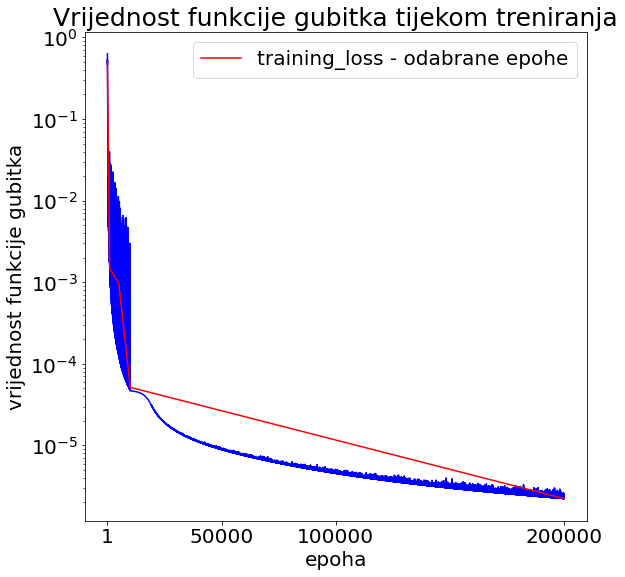

In [86]:
# crtamo loss (pogrešku modela) za odabrane epohe i uredimo graf
print(history.history.keys())
loss_train = history.history['loss']
loss_needed = [loss_epoch1, loss_epoch10, loss_epoch1000, loss_epoch5000, loss_epoch10000, loss_epoch20000]
epoch_my = [1, 10, 1000, 5000, 10000, 200000]
fig = plt.figure(figsize=(9, 9))
plt.plot(1, loss[0], 'b', range(2,11), loss[1], 'b',  range(11,1001), loss[2], 'b', range(1001,5001), loss[3], 'b', range(5001, 10001), loss[4], 'b', range(10001,200001), loss[5], 'b')
plt.plot(epoch_my, loss_needed, 'r', label='training_loss - odabrane epohe')

plt.title('Vrijednost funkcije gubitka tijekom treniranja', fontsize = 25)
plt.yscale('log')
plt.xticks([1, 100000, 50000, 200000], fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('epoha', fontsize = 20)
plt.ylabel('vrijednost funkcije gubitka', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## Crtamo aproksimaciju rješenja nakon određenog broja epoha

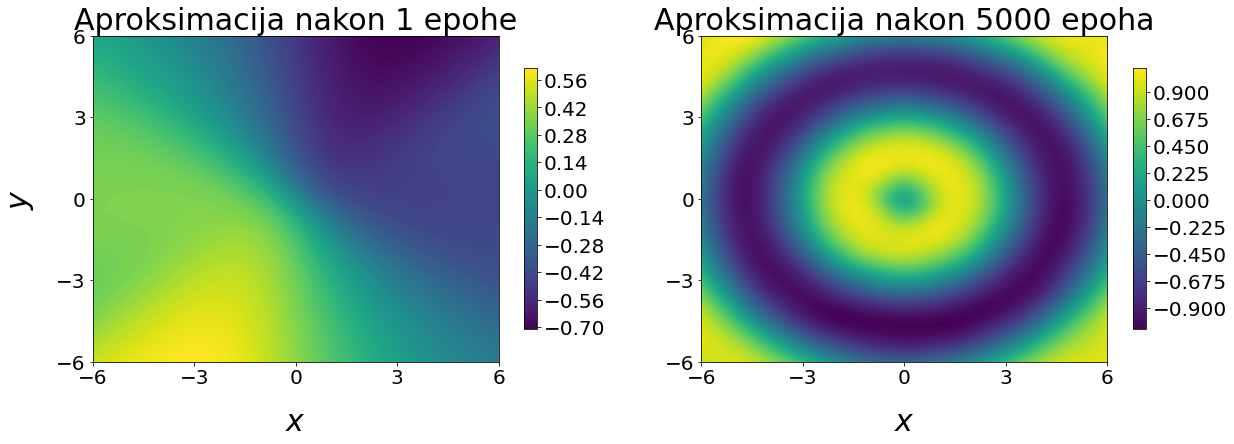

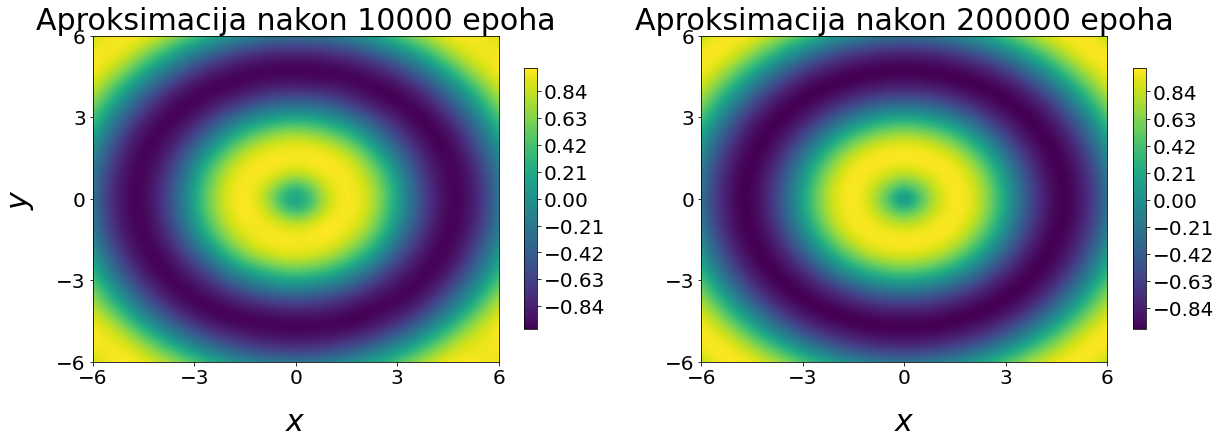

In [87]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
cb = ax.tricontourf(xy[:, 0], xy[:, 1], tf.reshape(y_epoch1, (len(y_epoch1, ))), levels=150, cmap = 'viridis')
plt.title('Aproksimacija nakon 1 epohe', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20)

###################################################################
ax = fig.add_subplot(1, 2, 2)
cb = ax.tricontourf(xy[:, 0], xy[:, 1], tf.reshape(y_epoch5000, (len(y_epoch5000, ))), levels=150, cmap = 'viridis') 
plt.title('Aproksimacija nakon 5000 epoha', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 

###################################################################
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
cb = ax.tricontourf(xy[:, 0], xy[:, 1], tf.reshape(y_epoch10000, (len(y_epoch10000, ))), levels=150, cmap = 'viridis')
plt.title('Aproksimacija nakon 10000 epoha', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 

###################################################################
ax = fig.add_subplot(1, 2, 2)
cb = ax.tricontourf(xy[:, 0], xy[:, 1], tf.reshape(y_epoch20000, (len(y_epoch20000, ))), levels=150, cmap = 'viridis') #cmap="bwr") #cmap="RdBu_r")
plt.title('Aproksimacija nakon 200000 epoha', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 


## Test 1: ista domena, različiti ulazni podaci
Provodimo testiranje neuronske mreže na drugačijem skupu točaka od onih sa kojima je trenirala, ali su ulazni podaci iz iste domene. Računamo funkciju gubitka i uočavamo da je reda $10^{-6}$.
Grafički prikaz dodatno potvrđuje da se predviđanje neuronske mreže vizualno poklapa s rješenjem.
Konačnu provjeru radimo pomoću mjerenja relativne $L_2$ pogreške koristeći FEniCS paket.

In [88]:
## test1 modela - na drugačijem skupu točaka
xyt = np.mgrid[a:b:0.02, a:b:0.02].reshape(2,-1).T
zt = np.sin(np.sqrt(xyt[:, 0] ** 2 + xyt[:, 1] ** 2))

test_loss = model.evaluate(xyt, zt)
prediction = model.predict(xyt)
print(test_loss)

11250/11250 [==============================] - 5s 484us/step - loss: 2.5749e-06
2.574909331087838e-06


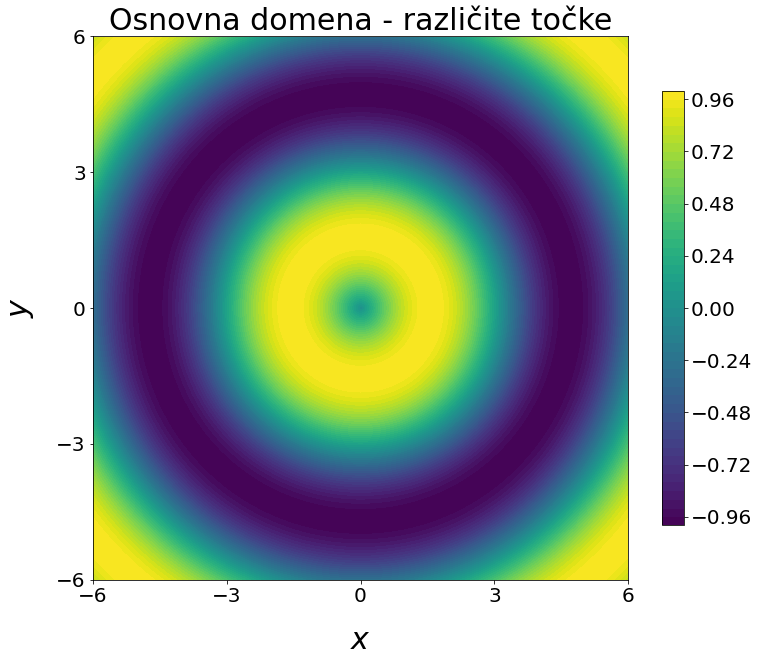

In [89]:

## grafički prikaz:
fig = plt.figure(figsize=(12, 10))#figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1)
cb = ax.tricontourf(xyt[:, 0], xyt[:, 1], zt, levels=50, cmap = 'viridis') #cmap="bwr") #cmap="RdBu_r")
#plt.colorbar(cb)
plt.title('Osnovna domena - različite točke', fontsize = 30)
plt.xticks([a, a/2, 0, b/2, b], fontsize = 20)
plt.yticks([a, a/2, 0, b/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20, pad=0.05)
cbar.ax.tick_params(labelsize=20) 


## Relativna pogreška u $L_2$ normi

Koristimo paket FEniCS, koji u sebi ima funkcije za izračun normi.

In [90]:
##################################################
##### obtain coordinates of the FEniCS mesh  #####
##################################################

element = V.element()
dofmap = V.dofmap()
indices_d = np.zeros(len(func.vector()[:])).astype('int')
xF = np.zeros((len(func.vector()[:]), 2))
#xF2 = np.zeros((len(func.vector()[:]), 3))
max = 0
min = 0

for cell in cells(mesh):
    #print(element.tabulate_dof_coordinates(cell))   # indices in func.vector(), 6 per cell for deg2
    #print(dofmap.cell_dofs(cell.index()))           # points corresponding to baove (6 pts for deg 2)
    for i in range(len(element.tabulate_dof_coordinates(cell))):
      indices = dofmap.cell_dofs(cell.index())
      points = element.tabulate_dof_coordinates(cell)
      
      #indices_d[ int(np.round(np.abs(-10 - points[i, 0])*5,  decimals=1)), int(np.round(np.abs(-10 - points[i, 1])*5,  decimals=1)) ] = indices[i]
      xF[indices[i]] = points[i]
      #xF2[i] = points[i]

print('FEniCS mesh points obtained successfully!')

FEniCS mesh points obtained successfully!


In [91]:
## predviđanje neuronske mreže u točkama mesha
NNfunc = tf.reshape(model(xF), (len(xF), ))

## kreiramo funkciju u FEniCS-u, u prostoru V i postavljamo vrijednosti prema predviđanju neuronske mreže
NNfuncF = Function(V)
for i in range(len(func.vector()[:])):
  NNfuncF.vector()[i] = NNfunc[i]

/usr/lib/petsc/lib/python3/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


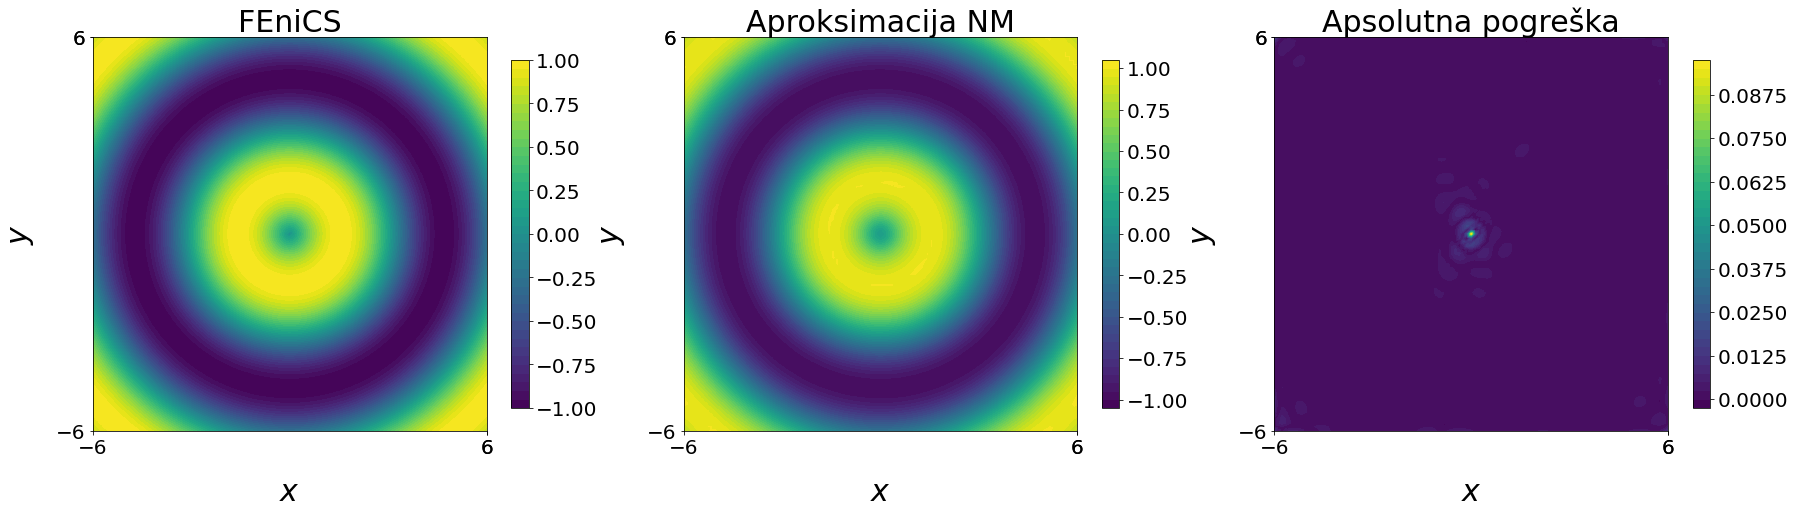

In [92]:
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(131)
cb = plot(funcF, interactive=True)
plt.title('FEniCS', fontsize = 30)
plt.xticks([a, (b-a)/2, b], fontsize = 20)
plt.yticks([a, (b-a)/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20,  pad=0.05)
cbar.ax.tick_params(labelsize=20)
###################################################

#fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(132)
cb = plot(NNfuncF, interactive=True)
plt.title('Aproksimacija NM', fontsize = 30)
plt.xticks([a, (b-a)/2, b], fontsize = 20)
plt.yticks([a, (b-a)/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20,  pad=0.05)
cbar.ax.tick_params(labelsize=20)
###################################################

#fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(133)
cb = plot(abs(funcF-NNfuncF), interactive=True)
plt.title('Apsolutna pogreška', fontsize = 30)
plt.xticks([a, (b-a)/2, b], fontsize = 20)
plt.yticks([a, (b-a)/2, b], fontsize = 20)
ax.set_xlabel('$x$', labelpad = 20, fontsize = 30)
ax.set_ylabel('$y$', labelpad = 20, fontsize = 30)
cbar = fig.colorbar(cb, shrink=0.8, aspect=20,  pad=0.05)
cbar.ax.tick_params(labelsize=20)


In [93]:
print('L2 relativna pogreška u odnosu na FEniCS funkciju:',np.round(errornorm(funcF, NNfuncF)/norm(funcF)*100, 2), '%')


L2 relativna pogreška u odnosu na FEniCS funkciju: 0.21 %
